In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
download.file("https://raw.githubusercontent.com/An-Dao/dsci_project/main/data/healthcare_dataset%202.csv","data/healthcare_data_read.csv")
health_data <- read_csv("data/healthcare_data_read.csv")

# Define age ranges
age_ranges <- c(0, 20, 30, 40, 50, 60, 70, 80, Inf)
age_labels <- c("0-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81+")

condition_levels <- c("Aspirin","Lipitor","Ibuprofen","Paracetamol","Penicillin")

gender_condition_levels <- c("Male","Female")

medical_condition_levels <- c("Asthma", "Obesity", "Arthritis", "Diabetes", "Cancer", "Hypertension")

blood_condition_levels <- c("A+" ,"A-" ,"B+" , "B-", "AB+", "AB-", "O+", "O-")

compress_health_data <- health_data |>
  clean_names() |>
  filter(test_results == "Normal") |>
  select(-c(date_of_admission:insurance_provider,room_number: discharge_date, name, test_results)) |>
  mutate(
    age_range = cut(age, breaks = age_ranges, labels = age_labels, include.lowest = TRUE),
    medication = factor(medication, levels = condition_levels),
  
    blood_type = factor(blood_type, levels = blood_condition_levels),
    blood_type = as.numeric(blood_type),
      
    medical_condition = factor(medical_condition, levels = medical_condition_levels),
    medical_condition = as.numeric(medical_condition),
      
     gender = factor(gender, levels = gender_condition_levels),
    gender = as.numeric(gender),
      
  )


compress_health_data |> head(10)
write.csv(compress_health_data, "data/medical_condition_data.csv")

Rows: 10000 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): Name, Gender, Blood Type, Medical Condition, Doctor, Hospital, In...
dbl   (3): Age, Billing Amount, Room Number
date  (2): Date of Admission, Discharge Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,gender,blood_type,medical_condition,billing_amount,medication,age_range
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
35,1,7,1,47304.06,Lipitor,31-40
61,1,4,2,36874.90,Lipitor,61-70
51,1,8,3,18086.34,Paracetamol,51-60
55,2,8,3,13546.82,Aspirin,51-60
39,2,8,1,22788.24,Aspirin,31-40
72,2,1,4,13669.38,Aspirin,71-80
55,2,5,3,32263.62,Penicillin,51-60
54,1,2,1,41319.50,Paracetamol,51-60
81,1,6,2,21001.27,Lipitor,81+


In [3]:
set.seed(2000) 


health_split <- initial_split(compress_health_data, prop = 3/4, strata = medication)
health_training <- training(health_split)
health_testing <- testing(health_split)

In [4]:
#Using only training data, summarize the data in at least one table (this is exploratory data analysis). 
#An example of a useful table could be one that reports the number of observations in each class, 
#the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 


count_blood_type <- health_training |>
    group_by(blood_type)|>
    summarize(count = n())
count_blood_type 

count_age_range <- health_training |>
    group_by(age_range)|>
    summarize(count = n())
count_age_range

count_med_cond <- health_training |>
    group_by(medical_condition) |>
    summarize(count = n())
count_med_cond
count_medication <- health_training |>
    group_by(medication) |>
    summarize(count = n())
count_medication


blood_type,count
<dbl>,<int>
1,327
2,311
3,305
4,299
5,293
6,291
7,301
8,321


age_range,count
<fct>,<int>
0-20,116
21-30,341
31-40,367
41-50,327
51-60,368
61-70,369
71-80,366
81+,194


medical_condition,count
<dbl>,<int>
1,387
2,412
3,410
4,416
5,423
6,400


medication,count
<fct>,<int>
Aspirin,510
Lipitor,456
Ibuprofen,501
Paracetamol,469
Penicillin,512


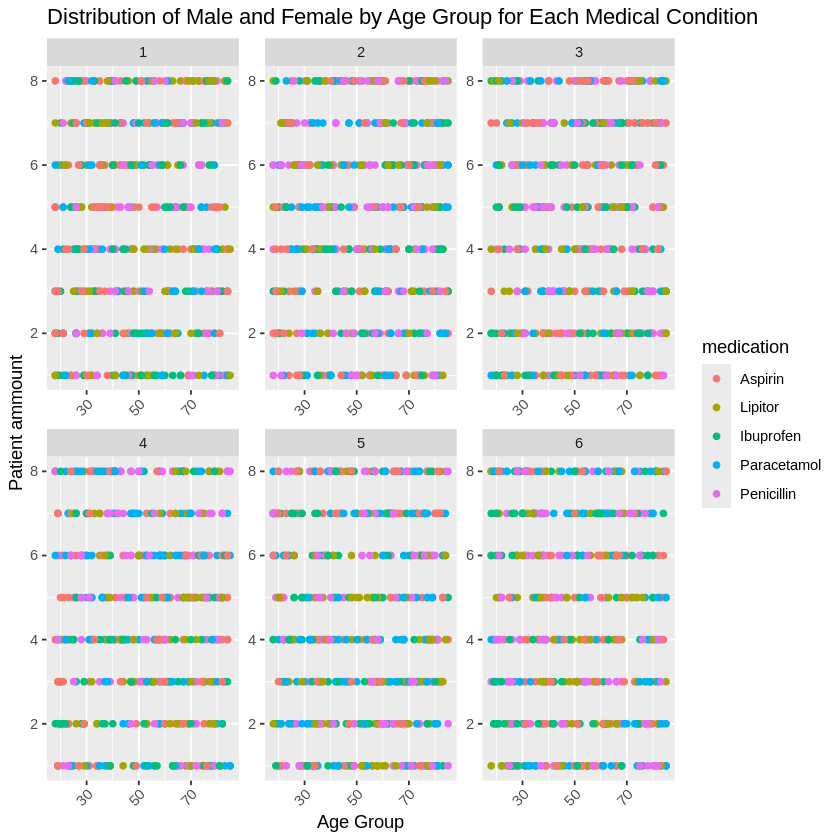

In [5]:

# training_plot <- summary_data |>
#    ggplot(aes(x = age_range, y = count, fill = gender)) + 
#     geom_point(stat = "identity", position = "dodge") +
#   facet_wrap(~ medical_condition, scales = "free") +
#   labs(title = "Distribution of Male and Female by Age Group for Each Medical Condition", x = "Age Group", y = "Patient ammount")+
#     theme(axis.text.x = element_text(angle = 45, hjust = 1))

# training_plot2 <- summary_data |>
#    ggplot(aes(x = blood_type, y = count, fill = gender)) + 
#     geom_bar(stat = "identity", position = "dodge") +
#   facet_wrap(~ medical_condition, scales = "free") +
#   labs(title = "Distribution of Male and Female by Blood type for Each Medical Condition", x = "Blood type", y = "Patient ammount")+
#     theme(axis.text.x = element_text(angle = 45, hjust = 1))
# training_plot
# training_plot2


training_plot3 <- compress_health_data |>
   ggplot(aes(x = age, y = blood_type, colour = medication)) + 
    geom_point() +
  facet_wrap(~ medical_condition, scales = "free") +
  labs(title = "Distribution of Male and Female by Age Group for Each Medical Condition", x = "Age Group", y = "Patient ammount")+
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
training_plot3

**Classification Analysis of Patients with Asthma Based on Age, Gender, and BloodType with the Healthcare Dataset**

**Introduction**
<br> Understanding and learning about human health is pivotal in health improvement within society. Healthcare is the system in which improvement of human health is developed through various practices and studies for the prevention and treatment of patients. For our group project, we will be analyzing a dataset found through Kaggle called “Healthcare Dataset”. This dataset includes patient information that simulates real-life healthcare files. Each column provides information about the patient, their date of admission, and services provided based on their condition. Through data classification, the organization and categorizing of new data through past data, we will answer the predictive question of “Will patients be diagnosed with asthma or not based on their age, gender, and blood type?”. We will be using the K-nearest neighbor classification algorithm to analyze our data to get our prediction result. 

**Preliminary Exploratory Data Analysis**
<br> Using our data from the web source https://www.kaggle.com/datasets/prasad22/healthcare-dataset/data, we aren't able to directly use the data in Jupyter Notebook. So before classification, we first need to read it into R by downloading the file and importing it into our repository then we get the directory of the raw file on GitHub. The data is read in and assigned to object "health_data". Although the data table is tidy, many variables are unnecessary for our project. We've shortened the table to age, gender, blood_type, medical_condition, and age_group. Of the age_group column, we will split the data into 8 groups of 0-20, 21-30, 31-40, 41-50, 51-60, 61-70, 71-80, 81+. Although every other age group is split by 10 years gap we decided to group 0-10 and 11-20 together as they lack amount of data. To split the data into training and testing sets we have picked a random seed of 2000 and split them by 3/4 with 3 parts going to the training set and the remaining for testing. We've grouped and found each variable's amount and concluded that data are fairly evenly distributed for all the groups we did. The main table is the "summary_data" which counts the number of patients that have medical conditions by "age_group", "blood_type" and "gender". We then visualize the "summary_data" into a bar graph showing the distribution of males and females having medical conditions. We can verify the even distribution between male and female patients in all "age_group" for each medical condition. This even spread will allow our model to have a higher precision.

**Methods**
<br> For our data analysis, we will be predicting a medical condition based on the age, gender, and blood type of the patient using "Healthcare Dataset". For this analysis, we will not need every column from the dataset. While the data is already tidy, we will only be using the age, gender, blood_type, medical_condition, and the age_group column. The age_group column will be made by splitting our patients into 8 possible age groups (0-20, 21-30, 31-40, 41-50, 51-60, 61-70, 71-80, 81+). These are the only variables we will need to predict our medical condition and visualize the results of our prediction. To visualize the results, we will use a bar graph that will show the distribution of male and female patients and their medical conditions. 

**Expected Outcomes and Significance** 
<br> In our data analysis project, we expect to find a correlation between the predictive factors of a patient’s age, gender, and blood type and their likelihood of having asthma. We will also expect to have a model such that when given said predictive factors will predict whether or not a patient will have asthma. Any correlations found could significantly impact healthcare strategies, enabling targeted preventive measures and personalized treatment plans. And the model could further help medical professionals diagnose patients. These discoveries may instigate additional investigations into the underlying reasons behind the observed correlations between asthma risk and specific factors, prompting scientists to develop research questions aimed at unraveling the root causes. This process could unveil systemic issues that contribute to the identified associations, fostering a deeper understanding of the complex interplay between various elements and asthma susceptibility.

In [8]:
set.seed(2000) 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")
recipe <- recipe(medication ~ age, blood_type, medical_condition, billing_amount, data = health_training) |>
    step_scale(age, blood_type, medical_condition, billing_amount) |>
    step_center(age, blood_type, medical_condition, billing_amount)
vfold <- vfold_cv(health_training, v = 5, strata = medication)
k <- tibble(c(2,3,4,5,6,7,8,9,10))
colnames(k) <- "neighbors"
knn_results <- workflow() |>
       add_recipe(recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = vfold, grid = k) |>
       collect_metrics()
knn_results
accuracies <- knn_results |> 
       filter(.metric == "accuracy")
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot





→ A | error:   Error in `step_scale()`:
               Caused by error in `prep()`:
               ! Can't subset columns that don't exist.
               ✖ Column `blood_type` doesn't exist.

There were issues with some computations   A: x1

There were issues with some computations   A: x5



Warning message:
“All models failed. Run `show_notes(.Last.tune.result)` for more information.”


ERROR: [1m[33mError[39m in `estimate_tune_results()`:[22m
[33m![39m All models failed. Run `show_notes(.Last.tune.result)` for more information.


In [7]:
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 20) |>
       set_engine("kknn") |>
       set_mode("classification")
best_fit <- workflow() |>
       add_recipe(recipe) |>
       add_model(best_spec) |>
       fit(data = health_training)
predictions <- predict(best_fit, health_testing) |>
               bind_cols(health_testing) |>
               mutate(medication = as_factor(medication)) |>
               select(-age_range)
predictions
metrics <- predictions  |>
           metrics(truth = medication, estimate = .pred_class)
metrics
conf_mat <- predictions  |>
            conf_mat(truth = medication, estimate = .pred_class)
conf_mat

.pred_class,age,gender,blood_type,medical_condition,billing_amount,medication
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Aspirin,61,1,4,2,36874.897,Lipitor
Lipitor,72,2,1,4,13669.378,Aspirin
Aspirin,55,2,5,3,32263.622,Penicillin
Aspirin,81,1,6,2,21001.275,Lipitor
Aspirin,34,1,7,6,16036.110,Paracetamol
Ibuprofen,78,2,4,5,25948.507,Lipitor
Aspirin,57,1,8,2,4679.119,Ibuprofen
Aspirin,56,2,4,4,33925.020,Aspirin
Aspirin,48,2,7,1,46144.940,Aspirin


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.2210012
kap,multiclass,0.0213331


             Truth
Prediction    Aspirin Lipitor Ibuprofen Paracetamol Penicillin
  Aspirin         109      88       105          88         98
  Lipitor          15      17        13          17         13
  Ibuprofen        34      40        43          40         45
  Paracetamol      12       8         7          12         15
  Penicillin        0       0         0           0          0

**Contributors:**
<br>*An Dao*, *Moya Ku*, Avireet Uppal, Kaelan Zhang